# Importing modules

In [ ]:
!pip install ucimlrepo numpy pandas matplotlib scikit-learn hmmlearn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 8.0 MB/s eta 0:00:00


# Defining Classifiers

## Graph Plotting

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classifier_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{classifier_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


# Function to plot ROC Curve and AUC
def plot_roc_curve(fpr, tpr, auc_value, classifier_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"ROC Curve for {classifier_name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Function to plot accuracy bar graph
def plot_accuracy_bar_graph(accuracies, test_sizes, classifier_name):
    plt.figure(figsize=(8, 6))
    plt.bar([f'{int(100*(1-size))}:{int(100*size)}' for size in test_sizes], accuracies, align='center')
    plt.title(f'Accuracy for {classifier_name} Across Different Test Sizes')
    plt.xlabel('Train-Test Split')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()


## **Gaussian HMM**

In [ ]:
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Function for Gaussian HMM
def train_gaussian_hmm(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5]):
    """
    Train and evaluate Gaussian HMM for multiple train-test splits.
    Only plots results for the best test size (highest accuracy).
    """
    best_accuracy = 0
    best_test_size = None
    best_cm = None
    best_class_report = None
    best_fpr = None
    best_tpr = None
    best_auc = None

    # Label Encoding
    le = LabelEncoder()
    Y_encoded = le.fit_transform(Y)  # Convert string labels to numeric labels

    # Store accuracies for plotting
    accuracies = []

    for test_size in test_sizes:
        print(f"Running Gaussian HMM with test size {test_size}...")

        # Split the data with a fixed random state for reproducibility
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=test_size, random_state=42)

        # Train Gaussian HMM with fixed random_state
        model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
        model.fit(X_train)
        Y_pred = model.predict(X_test)

        # Calculate accuracy and confusion matrix
        accuracy = accuracy_score(Y_test, Y_pred)
        cm = confusion_matrix(Y_test, Y_pred)
        class_report = classification_report(Y_test, Y_pred)

        # Store the accuracy for comparison
        accuracies.append(accuracy)

        # Track the best performing test size
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_test_size = test_size
            best_cm = cm
            best_class_report = class_report

            # --- ROC Curve and AUC Calculation ---
            Y_pred_proba = model.predict_proba(X_test)
            class_labels = np.unique(Y_encoded)

            Y_test_bin = label_binarize(Y_test, classes=class_labels)
            fpr, tpr, _ = roc_curve(Y_test_bin[:, 0], Y_pred_proba[:, 0])
            auc_value = roc_auc_score(Y_test_bin[:, 0], Y_pred_proba[:, 0])

            best_fpr = fpr
            best_tpr = tpr
            best_auc = auc_value

        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{class_report}")
        print("----------------------------------------------------------------------------------------------")

    # Plotting the results for the best test size
    print(f"Best Test Size: {best_test_size} with Accuracy: {best_accuracy}")

    # Plot confusion matrix
    print("plotting heatmap.........")
    plot_confusion_matrix(best_cm, "Gaussian HMM")
    print("---------------------------------------------------------------------------------------------------------------------")

    # Plot ROC Curve and AUC
    print("plotting ROC-AUC curve.........")
    plot_roc_curve(best_fpr, best_tpr, best_auc, "Gaussian HMM")
    print("---------------------------------------------------------------------------------------------------------------------")

    # Accuracy bar graph
    print("plotting bargraph.........")
    plot_accuracy_bar_graph(accuracies, test_sizes, "Gaussian HMM")
    print("---------------------------------------------------------------------------------------------------------------------")


## **Multinomial HMM**

In [ ]:
from hmmlearn.hmm import MultinomialHMM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

# Function to discretize data
def discretize_data(X, bins=5):
    """Discretizes continuous features into bins."""
    # Ensure that the discretizer returns integer values.
    discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    X_discretized = discretizer.fit_transform(X)

    # Check if the result is indeed integers
    X_discretized = np.floor(X_discretized).astype(int)  # Floor to ensure integer type

    # Ensure no negative values exist
    if np.any(X_discretized < 0):
        print("Error: Discretized data contains negative values.")
        return None

    return X_discretized

# Function for Multinomial HMM with discretized data
def train_multinomial_hmm(X, Y, test_sizes=[0.2, 0.3, 0.4, 0.5]):
    """
    Train and evaluate Multinomial HMM for multiple train-test splits.
    Only plots results for the best test size (highest accuracy).
    """
    best_accuracy = 0
    best_test_size = None
    best_cm = None
    best_class_report = None
    best_fpr = None
    best_tpr = None
    best_auc = None

    # Label Encoding
    le = LabelEncoder()
    Y_encoded = le.fit_transform(Y)  # Convert string labels to numeric labels

    # Discretize the data
    X_discretized = discretize_data(X)

    if X_discretized is None:
        print("Error: Failed to discretize the data. Exiting.")
        return

    # Store accuracies for plotting
    accuracies = []

    for test_size in test_sizes:
        print(f"Running Multinomial HMM with test size {test_size}...")

        # Split the data
        X_train, X_test, Y_train, Y_test = train_test_split(X_discretized, Y_encoded, test_size=test_size, random_state=89)

        # Train Multinomial HMM
        # The number of components should be equal to the number of unique classes
        model = MultinomialHMM(n_components=len(np.unique(Y_encoded)), n_iter=1000, random_state=89)
        model.fit(X_train)
        Y_pred = model.predict(X_test)

        # Calculate accuracy and confusion matrix
        accuracy = accuracy_score(Y_test, Y_pred)
        cm = confusion_matrix(Y_test, Y_pred)

        # Decode predicted labels back to original strings for classification report
        Y_pred_decoded = le.inverse_transform(Y_pred)
        Y_test_decoded = le.inverse_transform(Y_test)
        class_report = classification_report(Y_test_decoded, Y_pred_decoded)

        # Store the accuracy for comparison
        accuracies.append(accuracy)

        # Track the best performing test size
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_test_size = test_size
            best_cm = cm
            best_class_report = class_report

            # --- ROC Curve and AUC Calculation ---

            Y_pred_proba = model.predict_proba(X_test)
            class_labels = np.unique(Y_encoded)

            Y_test_bin = label_binarize(Y_test, classes=class_labels)
            fpr, tpr, _ = roc_curve(Y_test_bin[:, 0], Y_pred_proba[:, 0])
            auc_value = roc_auc_score(Y_test_bin[:, 0], Y_pred_proba[:, 0])

            best_fpr = fpr
            best_tpr = tpr
            best_auc = auc_value

        print(f"Accuracy: {accuracy}")
        print(f"Classification Report:\n{class_report}")
        print("----------------------------------------------------------------------------------------------")
    # Plotting the results for the best test size
    print(f"Best Test Size: {best_test_size} with Accuracy: {best_accuracy}")

    # Plot confusion matrix
    print("plotting heatmap.........")
    plot_confusion_matrix(best_cm, "Multinomial HMM")
    print("---------------------------------------------------------------------------------------------------------------------")

    # Plot ROC Curve and AUC (only if AUC was calculated)
    if best_auc is not None:
        print("plotting ROC-AUC curve.........")
        plot_roc_curve(best_fpr, best_tpr, best_auc, "Multinomial HMM")
        print("---------------------------------------------------------------------------------------------------------------------")
    else:
        print("ROC Curve and AUC not plotted: Only one class present in the best test split.")

    # Accuracy bar graph
    print("plotting bargraph.........")
    plot_accuracy_bar_graph(accuracies, test_sizes, "Multinomial HMM")
    print("---------------------------------------------------------------------------------------------------------------------")



# Data Fetching

## 1. **Ionosphere dataset**

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ionosphere = fetch_ucirepo(id=52)

In [ ]:
import pandas as pd
import numpy as np

# Convert features and targets into DataFrames
ionosphere_features = pd.DataFrame(ionosphere.data.features, columns=ionosphere.data.feature_names)
ionosphere_targets = pd.DataFrame(ionosphere.data.targets, columns=ionosphere.data.target_names)

# Optionally, combine features and target into a single DataFrame
ionosphere_dataset = pd.concat([ionosphere_features, ionosphere_targets], axis=1)
ionosphere_dataset.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute26,Attribute27,Attribute28,Attribute29,Attribute30,Attribute31,Attribute32,Attribute33,Attribute34,Class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [ ]:
ionosphere_dataset.isnull().sum()

,0
Attribute1,0
Attribute2,0
Attribute3,0
Attribute4,0
Attribute5,0
Attribute6,0
Attribute7,0
Attribute8,0
Attribute9,0
Attribute10,0


###  Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
scaler = StandardScaler()
# Step 2: Fit the scaler on the features and transform
scaled_features = scaler.fit_transform(ionosphere_features)
# Step 3: Convert scaled features back to DataFrame (to preserve column names)
ionosphere_features_scaled = pd.DataFrame(scaled_features, columns=ionosphere_features.columns)

### Gaussian HMM Classifier

Running Gaussian HMM with test size 0.2...
Accuracy: 0.7605633802816901
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.86      0.74        28
           1       0.88      0.70      0.78        43

    accuracy                           0.76        71
   macro avg       0.77      0.78      0.76        71
weighted avg       0.79      0.76      0.76        71

----------------------------------------------------------------------------------------------
Running Gaussian HMM with test size 0.3...
Accuracy: 0.1509433962264151
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.38      0.25        39
           1       0.04      0.01      0.02        67

    accuracy                           0.15       106
   macro avg       0.11      0.20      0.14       106
weighted avg       0.09      0.15      0.11       106

-------------------------------------------------------------

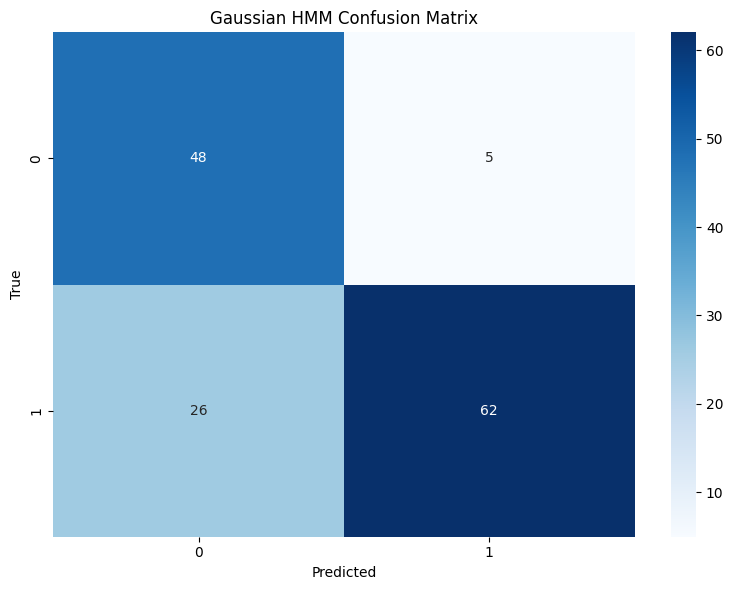

---------------------------------------------------------------------------------------------------------------------
plotting ROC-AUC curve.........


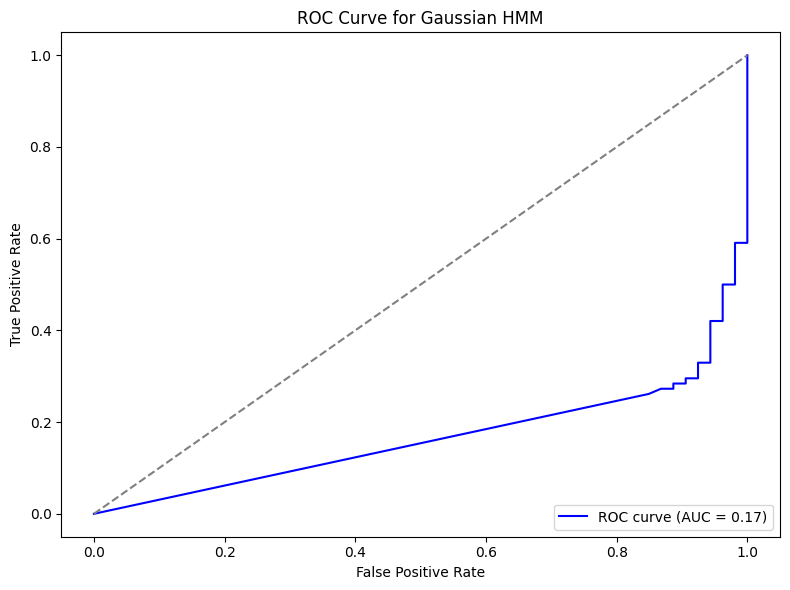

---------------------------------------------------------------------------------------------------------------------
plotting bargraph.........


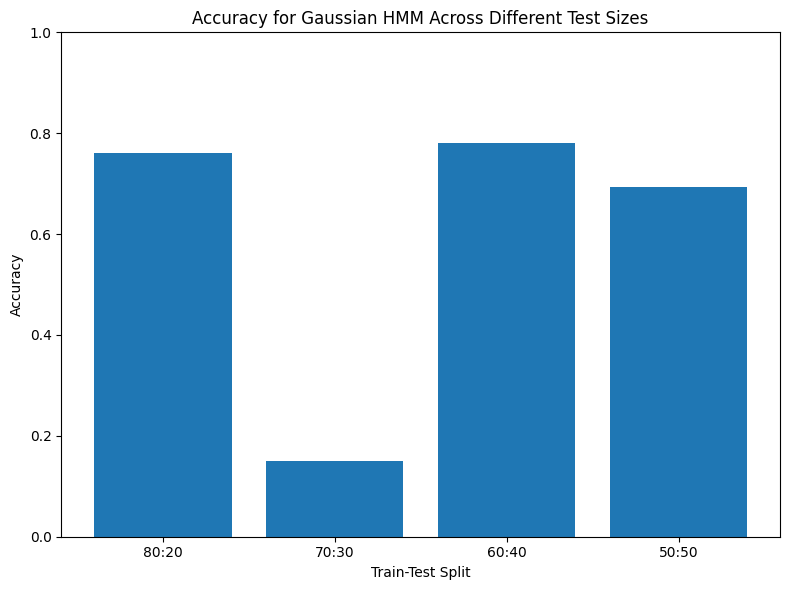

---------------------------------------------------------------------------------------------------------------------


In [ ]:
train_gaussian_hmm(ionosphere_features_scaled, ionosphere_targets['Class'], test_sizes=[0.2, 0.3, 0.4, 0.5])


### Multionomial HMM Classifier

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Running Multinomial HMM with test size 0.2...
Accuracy: 0.4647887323943662
Classification Report:
              precision    recall  f1-score   support

           b       0.42      0.89      0.57        28
           g       0.73      0.19      0.30        43

    accuracy                           0.46        71
   macro avg       0.57      0.54      0.43        71
weighted avg       0.60      0.46      0.40        71

----------------------------------------------------------------------------------------------
Running Multinomial HMM with test size 0.3...
Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           b       0.43      0.90      0.58        41
           g       0.80      0.25      0.38        65

    accuracy                           0.50       106
   macro avg       0.62      0.57      0.48       106
weighted avg       0.66      0.50      0.46       106

----------------------------------------------------------------------

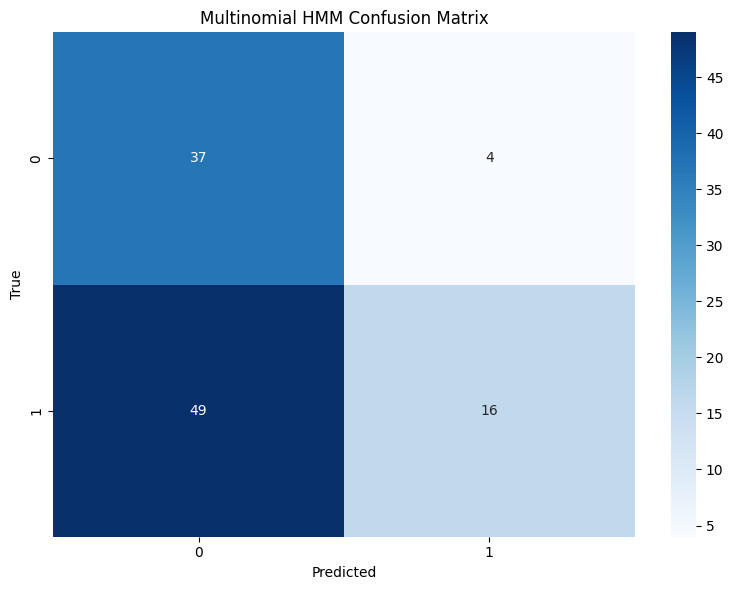

---------------------------------------------------------------------------------------------------------------------
plotting ROC-AUC curve.........


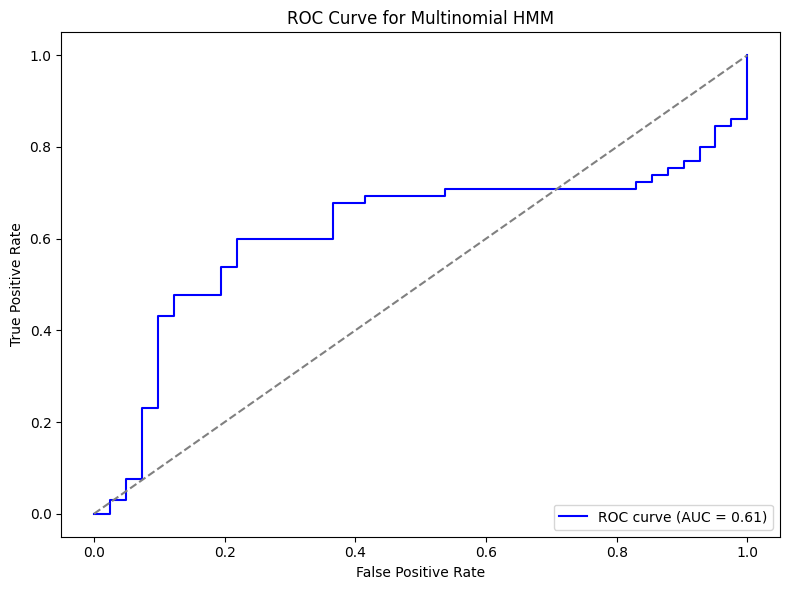

---------------------------------------------------------------------------------------------------------------------
plotting bargraph.........


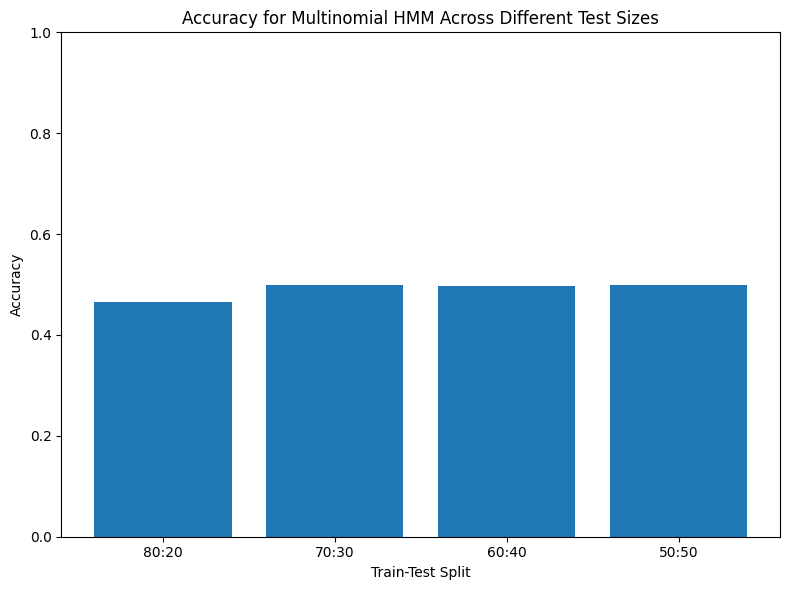

---------------------------------------------------------------------------------------------------------------------


In [ ]:
train_multinomial_hmm(ionosphere_features_scaled, ionosphere_targets['Class'], test_sizes=[0.2, 0.3, 0.4, 0.5])

## 2. **Wisconsin Breast Cancer Dataset:**

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

In [ ]:
import pandas as pd
import numpy as np

# Convert features and targets into DataFrames
cancer_features = pd.DataFrame(breast_cancer_wisconsin_diagnostic.data.features, columns=breast_cancer_wisconsin_diagnostic.data.feature_names)
cancer_targets = pd.DataFrame(breast_cancer_wisconsin_diagnostic.data.targets, columns=breast_cancer_wisconsin_diagnostic.data.target_names)

# Optionally, combine features and target into a single DataFrame
cancer_dataset = pd.concat([cancer_features, cancer_targets], axis=1)
cancer_dataset.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [ ]:
cancer_dataset.isnull().sum()

,0
radius1,0
texture1,0
perimeter1,0
area1,0
smoothness1,0
compactness1,0
concavity1,0
concave_points1,0
symmetry1,0
fractal_dimension1,0


### Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
scaler = StandardScaler()
# Step 2: Fit the scaler on the features and transform
scaled_features = scaler.fit_transform(cancer_features)
# Step 3: Convert scaled features back to DataFrame (to preserve column names)
cancer_features_scaled = pd.DataFrame(scaled_features, columns=cancer_features.columns)

### Gaussian HMM Classifier

Running Gaussian HMM with test size 0.2...
Accuracy: 0.9473684210526315
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

----------------------------------------------------------------------------------------------
Running Gaussian HMM with test size 0.3...
Accuracy: 0.10526315789473684
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.13      0.15       108
           1       0.04      0.06      0.05        63

    accuracy                           0.11       171
   macro avg       0.12      0.10      0.10       171
weighted avg       0.14      0.11      0.12       171

------------------------------------------------------------

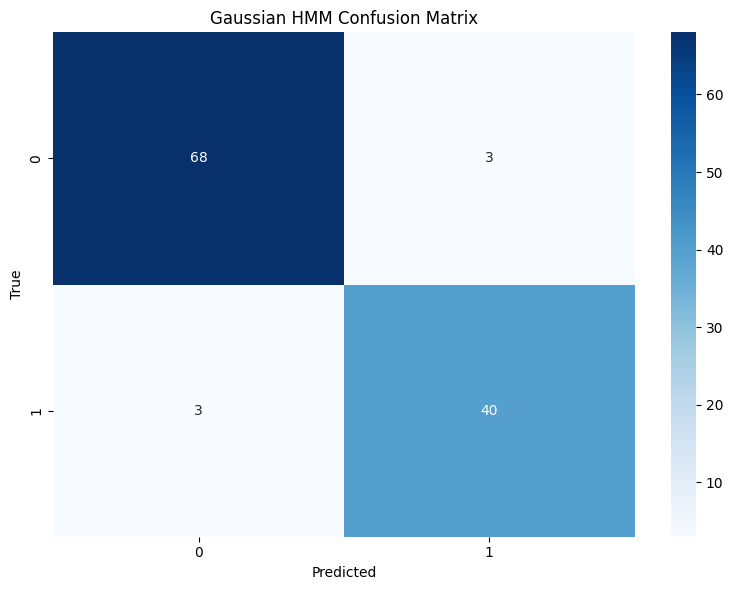

---------------------------------------------------------------------------------------------------------------------
plotting ROC-AUC curve.........


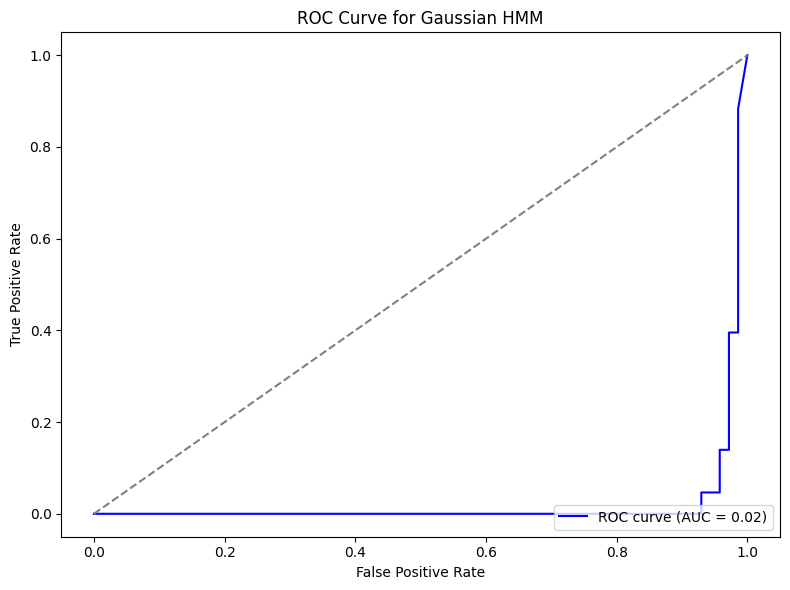

---------------------------------------------------------------------------------------------------------------------
plotting bargraph.........


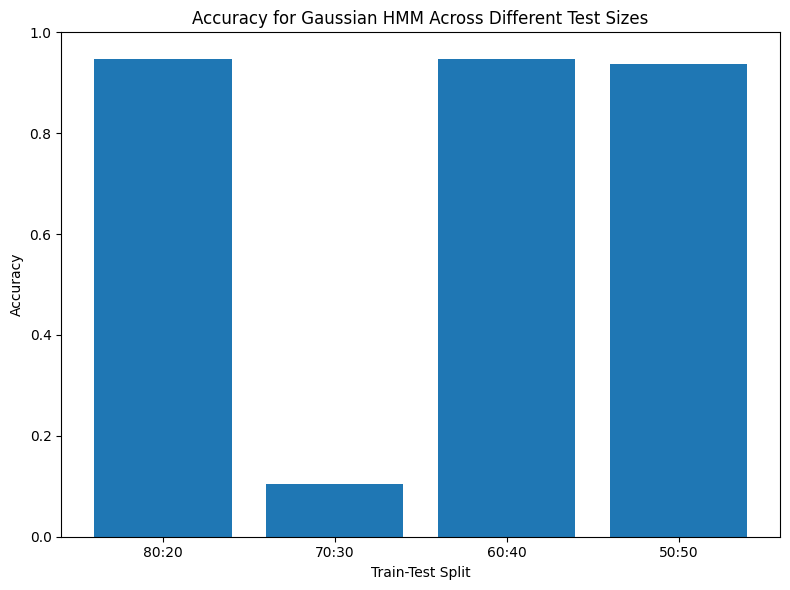

---------------------------------------------------------------------------------------------------------------------


In [ ]:
train_gaussian_hmm(cancer_features_scaled, cancer_targets['Diagnosis'], test_sizes=[0.2, 0.3, 0.4, 0.5])

### Multinomial HMM Classifier

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Running Multinomial HMM with test size 0.2...
Accuracy: 0.17543859649122806
Classification Report:
              precision    recall  f1-score   support

           B       0.27      0.24      0.25        67
           M       0.07      0.09      0.08        47

    accuracy                           0.18       114
   macro avg       0.17      0.16      0.17       114
weighted avg       0.19      0.18      0.18       114

----------------------------------------------------------------------------------------------
Running Multinomial HMM with test size 0.3...
Accuracy: 0.21052631578947367
Classification Report:
              precision    recall  f1-score   support

           B       0.33      0.25      0.29       107
           M       0.10      0.14      0.12        64

    accuracy                           0.21       171
   macro avg       0.22      0.20      0.20       171
weighted avg       0.24      0.21      0.22       171

-----------------------------------------------------

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Accuracy: 0.25877192982456143
Classification Report:
              precision    recall  f1-score   support

           B       0.39      0.35      0.37       142
           M       0.09      0.10      0.10        86

    accuracy                           0.26       228
   macro avg       0.24      0.23      0.23       228
weighted avg       0.28      0.26      0.27       228

----------------------------------------------------------------------------------------------
Running Multinomial HMM with test size 0.5...
Accuracy: 0.17894736842105263
Classification Report:
              precision    recall  f1-score   support

           B       0.27      0.21      0.24       173
           M       0.10      0.13      0.11       112

    accuracy                           0.18       285
   macro avg       0.18      0.17      0.17       285
weighted avg       0.20      0.18      0.19       285

----------------------------------------------------------------------------------------------
Best

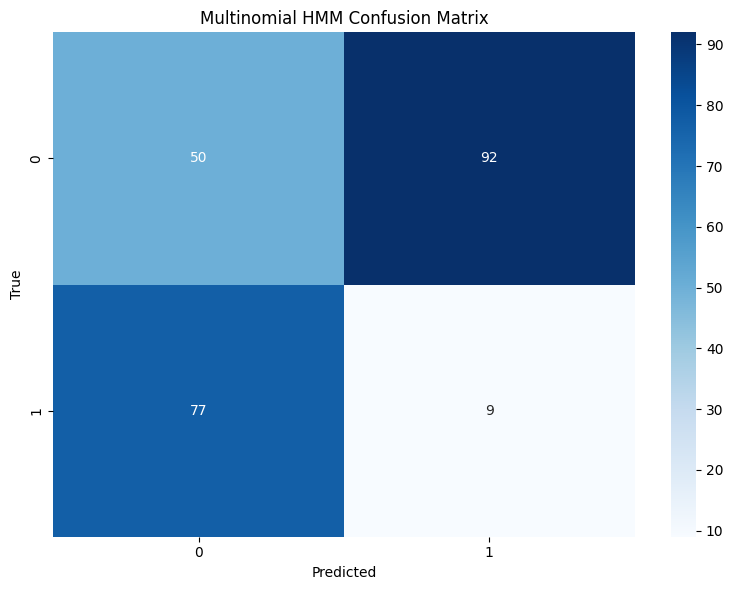

---------------------------------------------------------------------------------------------------------------------
plotting ROC-AUC curve.........


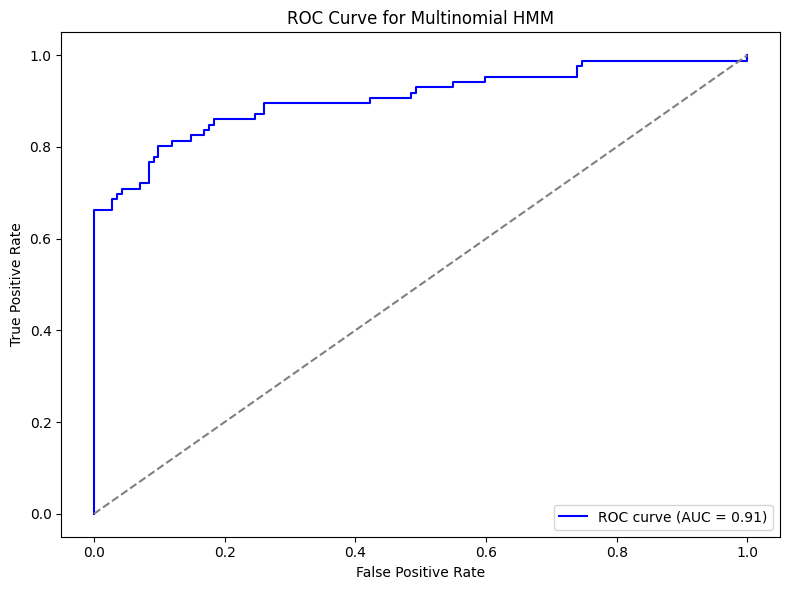

---------------------------------------------------------------------------------------------------------------------
plotting bargraph.........


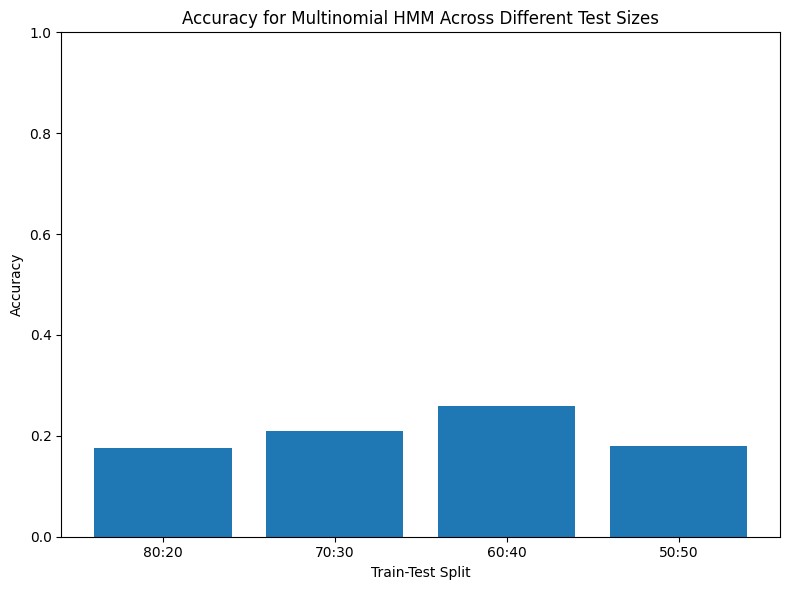

---------------------------------------------------------------------------------------------------------------------


In [ ]:
train_multinomial_hmm(cancer_features_scaled, cancer_targets['Diagnosis'], test_sizes=[0.2, 0.3, 0.4, 0.5])

# **CNN**

## CIFAR-10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

#normalization
train_images, test_images = train_images / 255.0, test_images / 255.0

print("CIFAR-10 dataset loaded successfully.")
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
CIFAR-10 dataset loaded successfully.
Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


### CNN model

In [ ]:
# Import necessary libraries from TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Initialize the Sequential model
model = Sequential()

# First Convolutional Block
# Use padding='same' to maintain the spatial dimensions
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Changed pool_size to 2x2
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Output Layer: 10 neurons with softmax activation
model.add(Dense(10, activation='softmax'))

# Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 815,018 (3.11 MB)

 Trainable params: 814,570 (3.11 MB)

 Non-trainable params: 448 (1.75 KB)

### model compilation

In [ ]:
# 1. Train the model
# Use the consistent variable names: x_train, y_train, x_test, y_test
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

# 2. Evaluate the model
# Use the same consistent variable names for the evaluation step
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.3762 - loss: 1.7432 - val_accuracy: 0.5938 - val_loss: 1.1209
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5940 - loss: 1.1271 - val_accuracy: 0.6912 - val_loss: 0.8887
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6794 - loss: 0.9247 - val_accuracy: 0.7266 - val_loss: 0.8025
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7189 - loss: 0.8196 - val_accuracy: 0.6203 - val_loss: 1.2245
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7436 - loss: 0.7480 - val_accuracy: 0.7465 - val_loss: 0.7400
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7681 - loss: 0.6774 - val_accuracy: 0.7527 - val_loss: 0.7318
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7860 - loss: 0.6241 - val_accuracy: 0.7867 - val_loss: 0.6555
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7994 - loss: 0.5

## MNIST

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets

(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = datasets.mnist.load_data()

#normalization
mnist_train_images = mnist_train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
mnist_test_images = mnist_test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

print("MNIST dataset loaded successfully.")
print(f"Train images shape: {mnist_train_images.shape}")
print(f"Train labels shape: {mnist_train_labels.shape}")
print(f"Test images shape: {mnist_test_images.shape}")
print(f"Test labels shape: {mnist_test_labels.shape}")

CIFAR-10 dataset loaded successfully.
Train images shape: (60000, 28, 28, 1)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


In [ ]:
# Import necessary libraries from TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Initialize the Sequential model
mnist_model = Sequential()

# First Convolutional Block
# Use padding='same' to maintain the spatial dimensions
mnist_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
mnist_model.add(BatchNormalization())
mnist_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2))) # Changed pool_size to 2x2
mnist_model.add(Dropout(0.25))

# Second Convolutional Block
mnist_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
mnist_model.add(BatchNormalization())
mnist_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Dropout(0.25))

# Third Convolutional Block
mnist_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
mnist_model.add(BatchNormalization())
mnist_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2)))
mnist_model.add(Dropout(0.25))

# Flatten Layer
mnist_model.add(Flatten())

# Fully Connected Layers
mnist_model.add(Dense(256, activation='relu'))
mnist_model.add(Dropout(0.25))

# Output Layer: 10 neurons with softmax activation
mnist_model.add(Dense(10, activation='softmax'))

# Compile the Model
mnist_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
mnist_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,066 (2.23 MB)

 Trainable params: 584,618 (2.23 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train
mnist_history = mnist_model.fit(
    mnist_train_images, mnist_train_labels,
    epochs=15,
    batch_size=64,
    validation_data=(mnist_test_images, mnist_test_labels)
)

# Evaluate
test_loss, test_acc = mnist_model.evaluate(mnist_test_images, mnist_test_labels, verbose=2)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9961 - loss: 0.0144 - val_accuracy: 0.9955 - val_loss: 0.0253
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9976 - loss: 0.0084 - val_accuracy: 0.9952 - val_loss: 0.0260
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.9961 - val_loss: 0.0232
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9946 - val_loss: 0.0241
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9972 - loss: 0.0087 - val_accuracy: 0.9947 - val_loss: 0.0243
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.9958 - val_loss: 0.0294
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9971 - loss: 0.0109 - val_accuracy: 0.9955 - val_loss: 0.0244
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9975 - loss: 0.0089 - val_accuracy: 

# **VGG-16**

### CIFAR-10

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import numpy as np
from keras.models import Model
from keras.optimizers import Adam

# Use a data augmentation generator to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(train_images)

# 2. Build the Model from scratch
# Load the VGG16 base with random weights and without the top layers
base_model = VGG16(weights=None, include_top=False, input_shape=(32,32,3))

# Add a new classification head on top of the VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x) # Use GlobalAveragePooling for simplicity
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 3. Compile the Model
# Use a suitable learning rate for training from scratch
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 4. Train the Model in a single step
print("\nTraining the model from scratch...")
vgg_history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=30,
                    validation_data=(test_images, test_labels))

# 5. Evaluate the Final Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")

Model: "functional_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        65,66

 Total params: 15,046,858 (57.40 MB)

 Trainable params: 15,045,578 (57.39 MB)

 Non-trainable params: 1,280 (5.00 KB)


Training the model from scratch...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 74ms/step - accuracy: 0.1532 - loss: 2.5668 - val_accuracy: 0.1362 - val_loss: 2.7775
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.2041 - loss: 1.9419 - val_accuracy: 0.2094 - val_loss: 2.2372
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.2950 - loss: 1.7770 - val_accuracy: 0.1298 - val_loss: 4.7294
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.3714 - loss: 1.5750 - val_accuracy: 0.3644 - val_loss: 1.7125
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.4242 - loss: 1.4592 - val_accuracy: 0.4662 - val_loss: 1.3612
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.4728 - loss: 1.3770 - val_accuracy: 0.4666 - val_loss: 1.5189
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.5035 - loss: 1.3041 - val_accuracy: 0.4007 - val_loss: 1.6510
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.5334 - loss: 1.2472 - val_accurac

### MNIST

In [ ]:
# 1️⃣ Load MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = datasets.mnist.load_data()

# 2️⃣ Preprocess: Resize to (32,32) and convert to 3 channels
mnist_train_images = np.stack((mnist_train_images,)*3, axis=-1)  # make 3 channels
mnist_test_images = np.stack((mnist_test_images,)*3, axis=-1)

mnist_train_images = tf.image.resize(mnist_train_images, (32, 32)).numpy()
mnist_test_images = tf.image.resize(mnist_test_images, (32, 32)).numpy()

# Normalize pixel values
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0

print("MNIST dataset prepared for VGG16:")
print(f"Train images shape: {mnist_train_images.shape}")
print(f"Test images shape: {mnist_test_images.shape}")


MNIST dataset prepared for VGG16:
Train images shape: (60000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
import numpy as np


#  Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
)
datagen.fit(mnist_train_images)

#  Build VGG16 base model
base_model = VGG16(weights=None, include_top=False, input_shape=(32, 32, 3))

#  Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 6️⃣ Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()




Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,66

 Total params: 15,046,858 (57.40 MB)

 Trainable params: 15,045,578 (57.39 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
#  Train
print("\nTraining the VGG16 model on MNIST...")
history = model.fit(
    datagen.flow(mnist_train_images, mnist_train_labels, batch_size=64),
    epochs=15,
    validation_data=(mnist_test_images, mnist_test_labels)
)

#  Evaluate
test_loss, test_acc = model.evaluate(mnist_test_images, mnist_test_labels, verbose=2)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")


Training the VGG16 model on MNIST...
Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.4713 - loss: 1.5785 - val_accuracy: 0.9183 - val_loss: 0.2644
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - accuracy: 0.9360 - loss: 0.2396 - val_accuracy: 0.9726 - val_loss: 0.0955
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 61s 65ms/step - accuracy: 0.9686 - loss: 0.1213 - val_accuracy: 0.8617 - val_loss: 1.7803
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.9773 - loss: 0.0938 - val_accuracy: 0.9793 - val_loss: 0.0751
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.9823 - loss: 0.0745 - val_accuracy: 0.9893 - val_loss: 0.0389
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.9847 - loss: 0.0610 - val_accuracy: 0.9921 - val_loss: 0.0333
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 60s 64ms/step - accuracy: 0.9865 - loss: 0.0572 - val_accuracy: 0.9729 - val_loss: 0.1247
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/ste

# **RNN**

### CIFAR-10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# 2. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

# 3. Reshape for RNN input (32 timesteps, 96 features)
train_images_rnn = train_images.reshape(-1, 32, 96)
test_images_rnn = test_images.reshape(-1, 32, 96)

# Custom data generator for RNN
def rnn_data_generator(generator):
    while True:
        x_batch, y_batch = next(generator)
        x_batch = x_batch.reshape(-1, 32, 96)
        yield x_batch, y_batch

train_gen = rnn_data_generator(datagen.flow(train_images, train_labels, batch_size=64))

# 4. Build the RNN model (Functional API)
inputs = Input(shape=(32, 96))

x = LSTM(256, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs, name="RNN_CIFAR10_Model")

# 5. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 6. Train the model
print("\nTraining the RNN model from scratch...")
rnn_history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // 64,
    epochs=30,
    validation_data=(test_images_rnn, test_labels)
)

# 7. Evaluate the model
test_loss, test_acc = model.evaluate(test_images_rnn, test_labels, verbose=2)
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")


Model: "RNN_CIFAR10_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 256)        │       361,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,442 (2.21 MB)

 Trainable params: 577,418 (2.20 MB)

 Non-trainable params: 1,024 (4.00 KB)


Training the RNN model from scratch...
Epoch 1/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.2091 - loss: 2.5342 - val_accuracy: 0.3180 - val_loss: 1.8348
Epoch 2/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.3337 - loss: 1.8289 - val_accuracy: 0.3917 - val_loss: 1.6542
Epoch 3/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3844 - loss: 1.6832 - val_accuracy: 0.3724 - val_loss: 1.7804
Epoch 4/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.4205 - loss: 1.5976 - val_accuracy: 0.4066 - val_loss: 1.5832
Epoch 5/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4491 - loss: 1.5251 - val_accuracy: 0.4953 - val_loss: 1.4071
Epoch 6/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4758 - loss: 1.4633 - val_accuracy: 0.5072 - val_loss: 1.3508
Epoch 7/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4960 - loss: 1.4182 - val_accuracy: 0.4725 - val_loss: 1.4310
Epoch 8/30
781/781 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/s

### MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets
import numpy as np

# 1️⃣ Load and normalize MNIST data
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = datasets.mnist.load_data()

# MNIST images are grayscale (28x28) → expand to (28, 28, 1)
mnist_train_images = np.expand_dims(mnist_train_images, -1)
mnist_test_images = np.expand_dims(mnist_test_images, -1)

# Normalize to [0,1]
mnist_train_images, mnist_test_images = mnist_train_images / 255.0, mnist_test_images / 255.0

print("MNIST dataset loaded successfully.")
print(f"Train images shape: {mnist_train_images.shape}")
print(f"Train labels shape: {mnist_train_labels.shape}")
print(f"Test images shape: {mnist_test_images.shape}")
print(f"Test labels shape: {mnist_test_labels.shape}")

# 2️⃣ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
datagen.fit(mnist_train_images)

# 3️⃣ Reshape MNIST for RNN input
# Treat each row (28 pixels) as a time step, and 28 features per step
train_images_rnn = mnist_train_images.reshape(-1, 28, 28)
test_images_rnn = mnist_test_images.reshape(-1, 28, 28)

# Custom generator to reshape augmented images for RNN
def rnn_data_generator(generator):
    while True:
        x_batch, y_batch = next(generator)
        x_batch = x_batch.reshape(-1, 28, 28)
        yield x_batch, y_batch

train_gen = rnn_data_generator(datagen.flow(mnist_train_images, mnist_train_labels, batch_size=64))

# 4️⃣ Build the RNN model using Functional API
inputs = Input(shape=(28, 28))

x = LSTM(128, return_sequences=True)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions, name="RNN_MNIST_Model")

# 5️⃣ Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 6️⃣ Train
print("\nTraining RNN model on MNIST dataset...")
history = model.fit(
    train_gen,
    steps_per_epoch=len(mnist_train_images) // 64,
    epochs=20,
    validation_data=(test_images_rnn, mnist_test_labels)
)

# 7️⃣ Evaluate
test_loss, test_acc = model.evaluate(test_images_rnn, mnist_test_labels, verbose=2)
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST dataset loaded successfully.
Train images shape: (60000, 28, 28, 1)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


Model: "RNN_MNIST_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 28, 128)        │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,682 (549.54 KB)

 Trainable params: 140,042 (547.04 KB)

 Non-trainable params: 640 (2.50 KB)


Training RNN model on MNIST dataset...
Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5374 - loss: 1.4747 - val_accuracy: 0.8795 - val_loss: 0.3830
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.9216 - loss: 0.2766 - val_accuracy: 0.9718 - val_loss: 0.0971
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.9494 - loss: 0.1799 - val_accuracy: 0.9792 - val_loss: 0.0759
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9628 - loss: 0.1350 - val_accuracy: 0.9839 - val_loss: 0.0515
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9686 - loss: 0.1146 - val_accuracy: 0.9827 - val_loss: 0.0648
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9747 - loss: 0.0942 - val_accuracy: 0.9858 - val_loss: 0.0477
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9742 - loss: 0.0937 - val_accuracy: 0.9903 - val_loss: 0.0363
Epoch 8/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/s

# **AlexNet**

## CIFAR-10

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, optimizers
import numpy as np

# -------------------- Load and preprocess CIFAR-10 --------------------
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

print("CIFAR-10 dataset loaded successfully.")
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# -------------------- Define AlexNet for CIFAR-10 --------------------
def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_alexnet()
model.summary()

# -------------------- Compile --------------------
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -------------------- Callbacks --------------------
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# -------------------- Train --------------------
history = model.fit(train_images, train_labels,
                    epochs=30,
                    batch_size=64,
                    validation_data=(test_images, test_labels),
                    callbacks=callbacks)

# -------------------- Evaluate --------------------
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# -------------------- Save --------------------
model.save('alexnet_cifar10.h5')
print("Model saved as alexnet_cifar10.h5")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
CIFAR-10 dataset loaded successfully.
Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,193,226 (12.18 MB)

 Trainable params: 3,192,842 (12.18 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.3494 - loss: 1.8008 - val_accuracy: 0.4600 - val_loss: 1.4928 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6044 - loss: 1.1357 - val_accuracy: 0.5929 - val_loss: 1.1774 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6819 - loss: 0.9192 - val_accuracy: 0.6518 - val_loss: 1.0075 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7315 - loss: 0.7924 - val_accuracy: 0.6450 - val_loss: 1.0349 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7634 - loss: 0.6959 - val_accuracy: 0.7285 - val_loss: 0.7965 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7925 - loss: 0.6165 - val_accuracy: 0.7348 - val_loss: 0.7737 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8130 - loss: 

Test accuracy: 0.7348
Model saved as alexnet_cifar10.h5


## MNIST

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

# -------------------- Load & preprocess MNIST --------------------
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# MNIST is (N,28,28) grayscale; expand channel dim to (28,28,1)
train_images = np.expand_dims(train_images, -1).astype('float32') / 255.0
test_images = np.expand_dims(test_images, -1).astype('float32') / 255.0

print("MNIST dataset loaded successfully.")
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# -------------------- AlexNet-style model for MNIST --------------------
def build_alexnet_mnist(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_alexnet_mnist()
model.summary()

# -------------------- Compile --------------------
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -------------------- Callbacks --------------------
cb = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# -------------------- Train --------------------
history = model.fit(train_images, train_labels,
                    epochs=25,
                    batch_size=128,
                    validation_data=(test_images, test_labels),
                    callbacks=cb)

# -------------------- Evaluate & Save --------------------
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

model.save('alexnet_mnist.h5')
print("Model saved as alexnet_mnist.h5")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST dataset loaded successfully.
Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 569,994 (2.17 MB)

 Trainable params: 569,802 (2.17 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.7635 - loss: 0.7319 - val_accuracy: 0.9705 - val_loss: 0.0966 - learning_rate: 0.0010
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9796 - loss: 0.0769 - val_accuracy: 0.9857 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9852 - loss: 0.0569 - val_accuracy: 0.9872 - val_loss: 0.0498 - learning_rate: 0.0010
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9883 - loss: 0.0442 - val_accuracy: 0.9905 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9909 - loss: 0.0335 - val_accuracy: 0.9849 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9916 - loss: 0.0306 - val_accuracy: 0.9926 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9933 - loss: 0.0266 

Test accuracy: 0.9941
Model saved as alexnet_mnist.h5


# GoogleNet

## CIFAR-10

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

# -------------------- Load & preprocess CIFAR-10 --------------------
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images.astype('float32') / 255.0, test_images.astype('float32') / 255.0

print("CIFAR-10 dataset loaded successfully.")
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# -------------------- Inception / GoogLeNet-style helper --------------------
def inception_module(x, f1, f3r, f3, f5r, f5, fp):
    b1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    b3 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    b3 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(b3)

    b5 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    b5 = layers.Conv2D(f5, (3,3), padding='same', activation='relu')(b5)
    b5 = layers.Conv2D(f5, (3,3), padding='same', activation='relu')(b5)

    bp = layers.MaxPooling2D((3,3), strides=1, padding='same')(x)
    bp = layers.Conv2D(fp, (1,1), padding='same', activation='relu')(bp)

    return layers.Concatenate(axis=-1)([b1, b3, b5, bp])

# -------------------- Build compact GoogLeNet for CIFAR --------------------
def build_googlenet_cifar(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = inception_module(x, 32, 32, 64, 16, 16, 16)
    x = inception_module(x, 64, 48, 96, 16, 32, 32)
    x = layers.MaxPooling2D((2,2))(x)

    x = inception_module(x, 96, 64, 128, 16, 32, 32)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name='googlenet_cifar')
    return model

model = build_googlenet_cifar()
model.summary()

# -------------------- Compile --------------------
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -------------------- Callbacks --------------------
cb = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# -------------------- Train --------------------
history = model.fit(train_images, train_labels,
                    epochs=40,
                    batch_size=64,
                    validation_data=(test_images, test_labels),
                    callbacks=cb)

# -------------------- Evaluate & Save --------------------
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

model.save('googlenet_cifar10.h5')
print("Model saved as googlenet_cifar10.h5")


## MNIST

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

# -------------------- Load & preprocess MNIST --------------------
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Expand to (N,28,28,1) and normalize
train_images = np.expand_dims(train_images, -1).astype('float32') / 255.0
test_images = np.expand_dims(test_images, -1).astype('float32') / 255.0

print("MNIST dataset loaded successfully.")
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# -------------------- Inception helper (works with 1-channel too) --------------------
def inception_module(x, f1, f3r, f3, f5r, f5, fp):
    b1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    b3 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    b3 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(b3)

    b5 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    b5 = layers.Conv2D(f5, (3,3), padding='same', activation='relu')(b5)
    b5 = layers.Conv2D(f5, (3,3), padding='same', activation='relu')(b5)

    bp = layers.MaxPooling2D((3,3), strides=1, padding='same')(x)
    bp = layers.Conv2D(fp, (1,1), padding='same', activation='relu')(bp)

    return layers.Concatenate(axis=-1)([b1, b3, b5, bp])

# -------------------- Build compact GoogLeNet for MNIST --------------------
def build_googlenet_mnist(input_shape=(28,28,1), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = inception_module(x, 16, 16, 32, 8, 8, 8)
    x = inception_module(x, 32, 24, 48, 8, 16, 16)
    x = layers.MaxPooling2D((2,2))(x)

    x = inception_module(x, 48, 32, 64, 8, 16, 16)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name='googlenet_mnist')
    return model

model = build_googlenet_mnist()
model.summary()

# -------------------- Compile --------------------
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -------------------- Callbacks --------------------
cb = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

# -------------------- Train --------------------
history = model.fit(train_images, train_labels,
                    epochs=30,
                    batch_size=128,
                    validation_data=(test_images, test_labels),
                    callbacks=cb)

# -------------------- Evaluate & Save --------------------
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

model.save('googlenet_mnist.h5')
print("Model saved as googlenet_mnist.h5")
